In [0]:
# general purpose libraries
import os
import shutil
from shutil import copyfile
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json

# for data loading and data transformation images
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# create neural network structure
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [0]:
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
IMAGE_DIR = "drive/My Drive/ml/MangaColorizer/image_17"
LOCAL_IMAGE_DIR = "image_17"
IMAGE_CSV = "drive/My Drive/ml/MangaColorizer/images17.csv"
LOCAL_IMAGE_CSV = "images17.csv"
IMAGE_JSON = "drive/My Drive/ml/MangaColorizer/meta_017_processed.json"
LOCAL_IMAGE_CSV = "meta_017_processed.json"

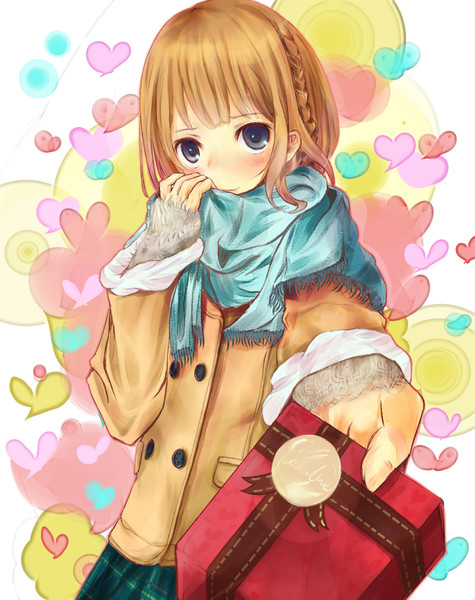

In [5]:
image = cv2.imread("drive/My Drive/ml/MangaColorizer/image_17/1782372.jpg")
cv2_imshow(image)

In [0]:
hist = cv2.calcHist([image], [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])

In [7]:
image.shape

(600, 475, 3)

In [8]:
print("3D histogram shape: %s, with %d values" % (hist.shape, hist.flatten().shape[0]))

3D histogram shape: (6, 6, 6), with 216 values


In [0]:
class MangaDataset(Dataset):
    """Manga Dataset"""

    def __init__(self, img_csv, label_file, root_dir):
        self.image_names = pd.read_csv(img_csv, index_col=0)
        self.root_dir = root_dir
        self.labels = json.load(open(label_file))

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(),
        ])

        self.tensor_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                               
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_dir = os.path.join(self.root_dir, self.image_names.iloc[idx, 0])
        print(img_dir)
        
        # apply transformations
        pil_img = Image.open(img_dir)
        transformed_pil_img = self.transform(pil_img)
        tensor_pil_img = self.tensor_transforms(transformed_pil_img)
        
        # get tag_id list
        image_name = os.path.splitext(self.image_names.iloc[idx, 0])[0]
        tag_ids = self.labels[image_name]["tag_ids"]

        return transformed_pil_img, tensor_pil_img, tag_ids

In [0]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    print(type(np.transpose(npimg, (1, 2, 0))))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
manga_dataset = MangaDataset(img_csv=IMAGE_CSV, label_file=IMAGE_JSON ,root_dir=IMAGE_DIR)

In [12]:
pil_img, img_tensor, img_tags = manga_dataset[1]

drive/My Drive/ml/MangaColorizer/image_17/1782372.jpg


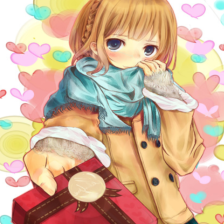

In [13]:
pil_img

<class 'numpy.ndarray'>


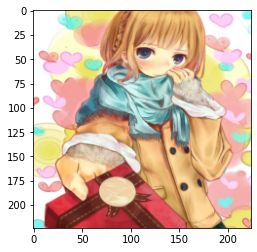

In [14]:
imshow(img_tensor)

In [15]:
img_tags

[12492, 382732]

In [0]:
def get_color_hist(img):
  """
  Converts image to a color histogram and processes the histogram.

  Parameters:
    img: A PIL image.

  Returns:
    A 216-dimensional binarized vector.
  """

  # create a 3d hist, quantized into 6 bins per RGB color dimension
  hist = cv2.calcHist([np.array(img)], [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])

  # normalize hist so that the values sum to 1
  cv2.normalize(hist, hist, alpha=1, norm_type=cv2.NORM_L1)

  # binarize the values using the median as the threshold
  threshold, hist = cv2.threshold(hist, np.median(hist), 1, cv2.THRESH_BINARY)

  # convert to vector
  hist = hist.flatten()

  return hist

In [27]:
get_color_hist(pil_img)

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.], dtype=float32)

In [0]:
class LowLevelFeatureNetwork(nn.Module):
    def __init__(self):
        super(LowLevelFeatureNetwork, self).__init__()
        # monochrome manga page only has a single channel so we start at 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        
    def forward(self, x1):
        x1 = F.relu(self.bn1(self.conv1(x1)))
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = F.relu(self.bn3(self.conv3(x1)))
        x1 = F.relu(self.bn4(self.conv4(x1)))
        x1 = F.relu(self.bn5(self.conv5(x1)))
        x1 = F.relu(self.bn6(self.conv6(x1)))
        
        x2 = x1.clone()
        
        return x1, x2

In [0]:
class MidLevelFeatureNetwork(nn.Module):
    def __init__(self):
        super(MidLevelFeatureNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [0]:
class GlobalFeatureNetwork(nn.Module):
    def __init__(self):
        super(GlobalFeatureNetwork, self).__init__()
        self.conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(7 * 7 * 512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        
    def forward(self, x):
        # conv layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        # resize
        x = x.view(-1, self.num_flat_features(x))

        # fully connected layers
        x = F.relu(self.fc1(x))
        
        # one more pass to create the fusion layer
        classification = F.relu(self.fc2(x))
        fusion = F.relu(self.fc3(classification))
        
        return fusion, classification
    
    def num_flat_features(self, x):
        # calculates dimensions of conv layer without batch size
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
class FusionLayer(nn.Module):
      def __init__(self):
        super(FusionLayer, self).__init__()
        self.conv1 = nn.Conv2d(512, 256, 1)
        self.bn1 = nn.BatchNorm2d(256)
      
      def forward(self, mid, global_layer):
        x = self.fuse_layers(mid, global_layer)
        x = F.relu(self.bn1(self.conv1(x)))

        return x

      def fuse_layers(self, mid, global_layer):
          dim3_global = global_layer.unsqueeze(-1).expand(32, 256, 28)
          dim4_global = dim3_global.unsqueeze(-1).expand(32, 256, 28, 28)

          return torch.cat((mid, dim4_global), 1)

In [0]:
class ColorizationNetwork(nn.Module):
    def __init__(self):
        super(ColorizationNetwork, self).__init__()
        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.upsample(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.upsample(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        return x

In [0]:
class ClassificationLayer(nn.Module):
    def __init__(self):
        super(ClassificationLayer, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 205)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [0]:
class DiscriminatorLayer(nn.Module):
    def __init__(self):
        super(DiscriminatorLayer, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernal_size=4, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernal_size=4, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernal_size=4, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernal_size=4, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x

In [0]:
class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()
        self.LLFN = LowLevelFeatureNetwork()
        self.MLFN = MidLevelFeatureNetwork()
        self.FL = FusionLayer()
        self.GFN = GlobalFeatureNetwork()
        self.CL = ClassificationLayer()
        self.CN = ColorizationNetwork()
    
    def forward(self, x):
        x1, x2 = self.LLFN(x)

        # mid level feature network
        x1 = self.MLFN(x1)
        
        # global feature network
        fusion, classification = self.GFN(x2)

        # fusion layer
        x = self.FL(x1, fusion)

        # classification network
        label_dist = self.CL(classification)

        # colorization network
        img = self.CN(x)

        return img, label_dist

In [0]:
t = torch.randn(32, 1, 224, 224)
final_cnn = ColorizationCNN()

In [0]:
pred_img, pred_label = final_cnn(t)

In [0]:
pred_img.size()

torch.Size([32, 3, 112, 112])

Function to create a csv of the image names

In [0]:
def create_csv(image_dir, image_csv_name):
    """
    Function to create a csv from the directory of images.

    Parameters:
        image_dir: Directory where all the images are located.
        image_csv_name: Name of the csv you want to output to.
    """
    # create a dict with all csv names
    counter = 0
    image_dict = {}
    for image in images:
        image_dict[counter] = [images]
        counter += 1

    # create a pandas df from the dict
    image_df = pd.DataFrame.from_dict(image_dict, columns=["image_name"], orient="index")

    # convert the pandas df to csv
    image_df.to_csv(image_csv_name)

Function to copy images from each file into a single file

In [0]:
def copy_into_single_file(source_list, dest):
    """
    Copies images present in multiple files into a single file.

    Parameters:
        source_list: List of source files to copy from.
        dest: The file you want to copy the images into.
    """
    for files in source_list:
        if "dataset" in files:
            for images in os.listdir(files):
                copyfile(files + "/" + images, dest + "/" + images)

Function to preprocess the image metadata json file

In [0]:
def preprocess_json(json_file):
    """
    Converts nico image metadata into a dict idenfiable by image id.
    
    Parameters:
        json_file: Name of the json file.
    """
    with open(json_file) as jsonfile:
        image_list = json.load(jsonfile)
    
    for image in image_list:
        # remove the id key and place it in a variable
        img_id = image.pop("image_id")
        img_dict[img_id] = image
    
    # get original name of file
    file_name = os.path.splitext(json_file)[0]
    
    with open("{}_processed.json".format(file_name), "w") as processed_json_file:
        json.dump(img_dict, processed_json_file, indent=2)

In [0]:
a = torch.randn(32, 256, 28, 28)
b = torch.randn(32, 256, 28, 28)
c = torch.cat((a, b), dim=1)
c.size()

torch.Size([32, 512, 28, 28])